# 와인 품종 분류

## 패키지 로딩

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

## 데이터 로딩 및 확인

In [4]:
wine = load_wine()
# print(wine.DESCR)
X = wine.data
y = wine.target
df = pd.DataFrame(X, columns=wine.feature_names)
df['class'] = y
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [5]:
print(df['class'].value_counts)

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: class, Length: 178, dtype: int32>


## 데이터 스케일링 및 분할

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaled_X = MinMaxScaler().fit_transform(X)
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10, stratify=y)

## 모델 생성
- RandomForestClassifier 파라메터
    - bootstrap : 부트스트랩 사용여부(True면 부트스트랩 표본으로 학습, False 이면 표본 전체를 이용하여 학습)
    - criterion: 트리 분할에 사용할 알고리즘  (gini, entropy)
    - max_depth : 나무의 최대 깊이
    - min_samples_split: 노드를 분할하는데 필요한 최소 샘플 수
    - n_estimators :랜덤포레스트 모델을 생성할 때 생성할 나무의 개수(default = 100)

In [7]:
model = RandomForestClassifier(n_estimators=400)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=400)

In [8]:
y_hat = model.predict(X_test)
print(f'정확도:{metrics.accuracy_score(y_test,y_hat):.3f}')
report = metrics.classification_report(y_test,y_hat)
print(report)

정확도:0.981
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



## 트리 시각화
- graphviz 패키지 설치
    - pip install graphviz

In [9]:
from sklearn.tree import export_graphviz

estimator = model.estimators_[2]
export_graphviz(estimator, out_file='tree.dot',
                class_names=wine.target_names,
                feature_names=wine.feature_names,
                precision=3, # 소수점 정밀도
                filled= True, # 클래스별 색깔 채우기
                rounded= True , # 박스모양을 둥글게
                )

In [10]:
import os
os.environ["PATH"]+=os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'

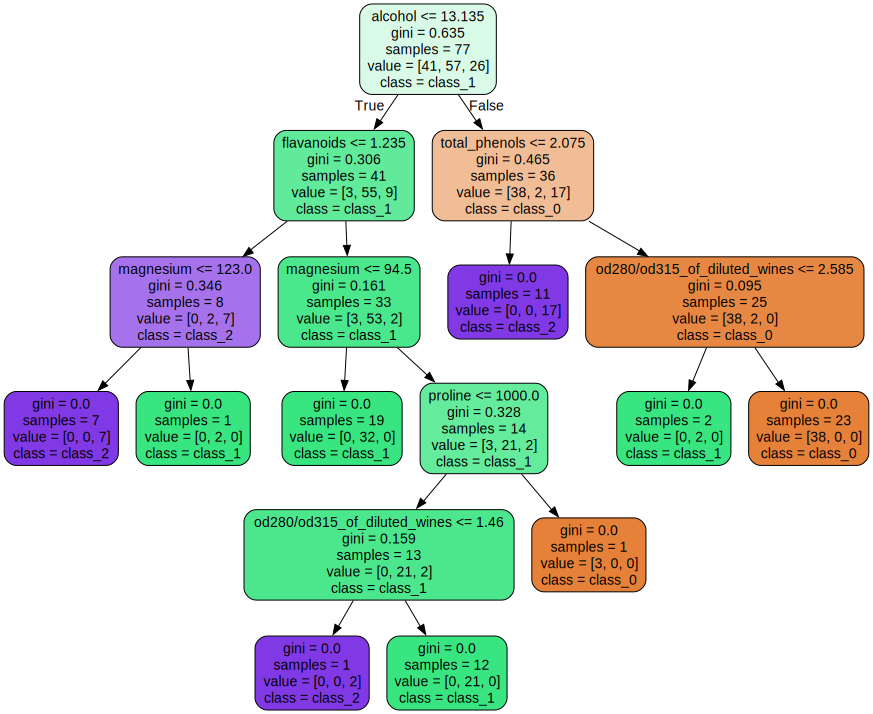

In [12]:
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## 하이퍼 파라메터 튜닝

In [15]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
params = {'max_depth':[6,8,10,12,14,16,20,24],
          'min_samples_split':[3,6,9,12,24],
          'n_estimators': [100,200,400,500]
          }

grid_dtree = GridSearchCV(model,params,cv= 5,scoring= 'accuracy')
grid_dtree.fit(scaled_X,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12, 14, 16, 20, 24],
                         'min_samples_split': [3, 6, 9, 12, 24],
                         'n_estimators': [100, 200, 400, 500]},
             scoring='accuracy')

In [16]:
print(f'최적의 파라메터 조합:{grid_dtree.best_params_}')
print(f'최적의 스코어: {grid_dtree.best_score_}')

최적의 파라메터 조합:{'max_depth': 12, 'min_samples_split': 3, 'n_estimators': 200}
최적의 스코어: 0.9888888888888889


## Feature importance
- Decsision Tree 알고리즘이 학습을 통해 규칙을 정하는데 있어 피처의 중요한 역할 지표를 제공하는 속성
- 일반적으로 값이 높을수록 해당 피처의 중요도가 높다는 의미로 해석

In [17]:
estimator = grid_dtree.best_estimator_
estimator.feature_importances_

array([0.10994442, 0.02770149, 0.01365348, 0.0260745 , 0.02853183,
       0.06950485, 0.14093937, 0.0090808 , 0.02307753, 0.20963884,
       0.07204633, 0.12934061, 0.14046596])

In [19]:
importance = {k:v for k,v in zip(wine.feature_names, estimator.feature_importances_)}
df_importance = pd.DataFrame(pd.Series(importance), columns =['importance'])
df_importance = df_importance.sort_values('importance', ascending = False)
df_importance

,importance
color_intensity,0.209639
flavanoids,0.140939
proline,0.140466
od280/od315_of_diluted_wines,0.129341
alcohol,0.109944
hue,0.072046
total_phenols,0.069505
magnesium,0.028532
malic_acid,0.027701
alcalinity_of_ash,0.026074


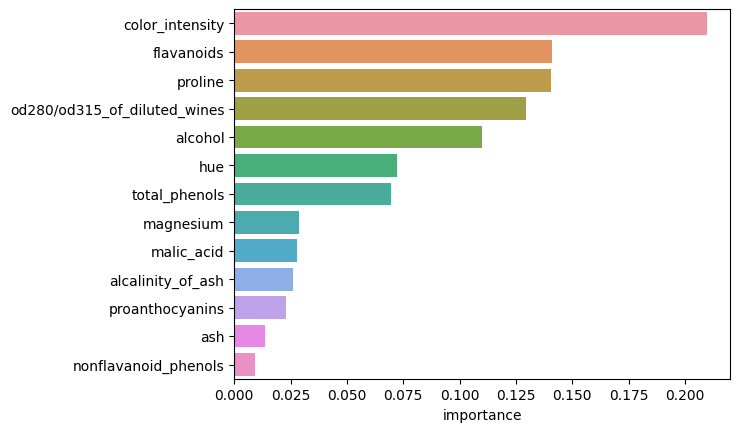

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.barplot(data = df_importance, x = 'importance',y =df_importance.index)
plt.show()